In [1]:
!pip install transformers datasets evaluate peft nltk rouge-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
  

Environment setup and imports

In [3]:
import os
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    Seq2SeqTrainingArguments,  # Note: change to Seq2SeqTrainingArguments
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
from peft import get_peft_model, LoraConfig, TaskType
import evaluate
from tqdm.auto import tqdm

# Set up environment
print("Setting up environment...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

Setting up environment...
Using device: cpu


 Load dataset


In [4]:
# Load a small sample from CNN/DailyMail
print("Loading small sample from CNN/DailyMail dataset...")
dataset = load_dataset("abisee/cnn_dailymail", "3.0.0")

# Create small samples for POC
SAMPLE_SIZE = 15
train_dataset = dataset["train"].select(range(SAMPLE_SIZE))
val_dataset = dataset["validation"].select(range(5))
test_dataset = dataset["test"].select(range(5))

print(f"Dataset samples loaded: {len(train_dataset)} train, {len(val_dataset)} validation, {len(test_dataset)} test")

Loading small sample from CNN/DailyMail dataset...
Dataset samples loaded: 15 train, 5 validation, 5 test


Preprocess data

In [5]:
# Preprocessing function
def preprocess_example(example):
    """Clean text by removing extra spaces and fixing punctuation"""
    article = ' '.join(example["article"].split())
    summary = ' '.join(example["highlights"].split())

    # Fix spacing around punctuation
    for punct in ['.', ',', '!', '?', ';', ':']:
        article = article.replace(f" {punct}", punct)
        summary = summary.replace(f" {punct}", punct)

    return {
        "article": article.strip(),
        "summary": summary.strip(),
        "id": example["id"]
    }

# Apply preprocessing
print("Preprocessing data...")
train_dataset = train_dataset.map(preprocess_example)
val_dataset = val_dataset.map(preprocess_example)
test_dataset = test_dataset.map(preprocess_example)

Preprocessing data...


Load model and setup LoRA

In [6]:
# Load model and tokenizer
print("Loading model and tokenizer...")
MODEL_NAME = "t5-small"  # Smaller model (60M parameters) good for beginners
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
base_model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)

# Setup LoRA for parameter-efficient fine-tuning
print("Setting up LoRA for parameter-efficient fine-tuning...")
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=8,                        # Rank of low-rank matrices
    lora_alpha=32,              # Parameter scaling
    lora_dropout=0.1,
    target_modules=["q", "v"],  # Only fine-tune query and value projection matrices
)

# Apply LoRA to model
model = get_peft_model(base_model, peft_config)
print(f"Trainable parameters: {model.print_trainable_parameters()}")

Loading model and tokenizer...
Setting up LoRA for parameter-efficient fine-tuning...
trainable params: 294,912 || all params: 60,801,536 || trainable%: 0.4850
Trainable parameters: None


Tokenize datasets

In [7]:
# Tokenization function
print("Tokenizing datasets...")
PREFIX = "summarize: "  # T5 requires task prefix

def tokenize_function(examples):
    # Prepare inputs with prefix
    inputs = [PREFIX + doc for doc in examples["article"]]

    # Tokenize inputs (articles)
    model_inputs = tokenizer(
        inputs,
        max_length=512,         # Limit input length
        padding="max_length",
        truncation=True,
    )

    # Tokenize targets (summaries)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["summary"],
            max_length=128,     # Limit summary length
            padding="max_length",
            truncation=True,
        )

    model_inputs["labels"] = labels["input_ids"]

    # Replace padding token id's with -100 in labels for loss calculation
    model_inputs["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in label]
        for label in model_inputs["labels"]
    ]

    return model_inputs

# Apply tokenization
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Tokenizing datasets...


Setup training arguments and trainer

In [9]:
import transformers
print("Transformers version:", transformers.__version__)

Transformers version: 4.51.3


In [13]:
# # Minimal training args compatible with transformers 4.51.3
# training_args = Seq2SeqTrainingArguments(
#     output_dir="./results_t5_cnn_lora",
#     per_device_train_batch_size=2,
#     per_device_eval_batch_size=2,
#     learning_rate=1e-3,
#     num_train_epochs=3,
#     predict_with_generate=True,
#     remove_unused_columns=False
# )

# Updated training arguments without wandb
training_args = Seq2SeqTrainingArguments(
    output_dir="./results_t5_cnn_lora",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=1e-3,
    num_train_epochs=3,
    predict_with_generate=True,
    remove_unused_columns=False,
    report_to=None  # This disables wandb and other reporting
)

# Setup evaluation metrics
print("Setting up evaluation metrics...")
rouge = evaluate.load("rouge")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    # Decode predictions
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 with pad token id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(pred.split()) for pred in decoded_preds]
    decoded_labels = ["\n".join(label.split()) for label in decoded_labels]

    # Compute ROUGE scores
    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    # Extract ROUGE f1 scores
    result = {key: value * 100 for key, value in result.items()}

    # Add mean generated length
    prediction_lens = [len(pred.split()) for pred in decoded_preds]
    result["gen_len"] = np.mean(prediction_lens)

    return result

# Setup data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True,
)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Setting up evaluation metrics...


<ipython-input-13-7cb0474b47c9>:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [14]:
# Fine-tune the model
print("Starting fine-tuning...")
trainer.train()

# Evaluate on test set
print("Evaluating fine-tuned model...")
test_results = trainer.evaluate(tokenized_test)
print("Test results:", test_results)

# Save the fine-tuned model
print("Saving fine-tuned model...")
trainer.save_model("./final_model")

Starting fine-tuning...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: veerabomma-s (veerabomma-s-northeastern-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss


Evaluating fine-tuned model...


Test results: {'eval_loss': 1.8993135690689087, 'eval_rouge1': 27.966507177033495, 'eval_rouge2': 8.907626994583516, 'eval_rougeL': 21.94178628389155, 'eval_rougeLsum': 27.983253588516742, 'eval_gen_len': 13.4, 'eval_runtime': 11.8942, 'eval_samples_per_second': 0.42, 'eval_steps_per_second': 0.252, 'epoch': 3.0}
Saving fine-tuned model...


In [15]:
# Test inference on examples
print("\nGenerating summaries for test examples...")
model.eval()
for i, example in enumerate(test_dataset):
    article = example["article"]
    reference_summary = example["summary"]

    # Prepare input for generation
    input_text = PREFIX + article
    input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids.to(device)

    # Generate summary
    outputs = model.generate(
        input_ids=input_ids,
        max_length=128,
        min_length=30,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True,
    )

    # Decode summary
    predicted_summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

    print(f"\nExample {i+1}:")
    print(f"Article (first 150 chars): {article[:150]}...")
    print(f"Reference summary: {reference_summary}")
    print(f"Predicted summary: {predicted_summary}")

print("\nFine-tuning completed successfully!")


Generating summaries for test examples...

Example 1:
Article (first 150 chars): (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisd...
Reference summary: Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June. Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis.
Predicted summary: the Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday. the Palestinians signed the ICC's founding Rome Statute in January. Israel and the United States opposed the Palestinians' efforts to join the body.

Example 2:
Article (first 150 chars): (CNN)Never mind cats having nine lives. A stray pooch in Washington State has used up at least three of her own after being hit by a car, apparently w...
Reference summary: Theia, a bully breed m

Additional Evaluation Metrics

In [ ]:
!pip install bert_score

In [20]:
import evaluate

# BERTScore - semantic similarity (higher is better)
bertscore = evaluate.load("bertscore")
def calculate_bertscore(predictions, references):
    results = bertscore.compute(
        predictions=predictions,
        references=references,
        lang="en"
    )
    return {"precision": np.mean(results["precision"]),
            "recall": np.mean(results["recall"]),
            "f1": np.mean(results["f1"])}

# METEOR - human correlation (higher is better)
meteor = evaluate.load("meteor")
def calculate_meteor(predictions, references):
    return meteor.compute(predictions=predictions, references=references)

# Apply these metrics to your test results
preds = []
refs = []
for i, example in enumerate(test_dataset):
    # Generate prediction for this example
    input_text = PREFIX + example["article"]
    input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids.to(device)
    outputs = model.generate(input_ids=input_ids, max_length=128)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

    preds.append(prediction)
    refs.append(example["summary"])

print("\nAdditional Metrics:")
print("BERTScore:", calculate_bertscore(preds, refs))
print("METEOR:", calculate_meteor(preds, refs))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Additional Metrics:


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore: {'precision': np.float64(0.8760390162467957), 'recall': np.float64(0.8802922368049622), 'f1': np.float64(0.8781285166740418)}
METEOR: {'meteor': np.float64(0.25584445671597134)}


Compare with Baseline Models
The most compelling comparison is with baseline models:

In [22]:
# First, get the actual keys in your test_results
print("Available keys in test_results:")
for key in test_results.keys():
    print(f"- {key}")

# Modified comparison function
def evaluate_and_compare():
    # Load untuned T5 model
    print("Loading baseline model...")
    baseline_model = T5ForConditionalGeneration.from_pretrained("t5-small")
    baseline_model.to(device)

    # Prepare test examples
    preds = []
    baseline_preds = []
    refs = []

    print("Generating predictions...")
    for i, example in enumerate(test_dataset):
        # Get article and reference summary
        article = example["article"]
        reference = example["summary"]
        refs.append(reference)

        # Prepare input
        input_text = PREFIX + article
        input_ids = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).input_ids.to(device)

        # Generate with fine-tuned model
        outputs = model.generate(input_ids=input_ids, max_length=128)
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        preds.append(prediction)

        # Generate with baseline model
        outputs = baseline_model.generate(input_ids=input_ids, max_length=128)
        baseline_prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        baseline_preds.append(baseline_prediction)

    # Calculate ROUGE for both models
    print("Calculating ROUGE scores...")
    tuned_results = rouge.compute(
        predictions=preds,
        references=refs,
        use_stemmer=True
    )

    baseline_results = rouge.compute(
        predictions=baseline_preds,
        references=refs,
        use_stemmer=True
    )

    # Convert to percentages
    tuned_results = {key: value * 100 for key, value in tuned_results.items()}
    baseline_results = {key: value * 100 for key, value in baseline_results.items()}

    # Display comparison
    print("\nComparison with Baseline (untuned) Model:")
    for metric in tuned_results.keys():
        if metric in baseline_results:
            print(f"{metric}: Tuned: {tuned_results[metric]:.2f} vs Baseline: {baseline_results[metric]:.2f}")
            print(f"Improvement: {tuned_results[metric] - baseline_results[metric]:.2f} points")

    return tuned_results, baseline_results

# Run the evaluation
tuned_results, baseline_results = evaluate_and_compare()

Available keys in test_results:
- eval_loss
- eval_rouge1
- eval_rouge2
- eval_rougeL
- eval_rougeLsum
- eval_gen_len
- eval_runtime
- eval_samples_per_second
- eval_steps_per_second
- epoch
Loading baseline model...
Generating predictions...
Calculating ROUGE scores...

Comparison with Baseline (untuned) Model:
rouge1: Tuned: 36.21 vs Baseline: 36.16
Improvement: 0.04 points
rouge2: Tuned: 9.68 vs Baseline: 7.98
Improvement: 1.70 points
rougeL: Tuned: 22.34 vs Baseline: 23.98
Improvement: -1.65 points
rougeLsum: Tuned: 22.41 vs Baseline: 24.09
Improvement: -1.68 points


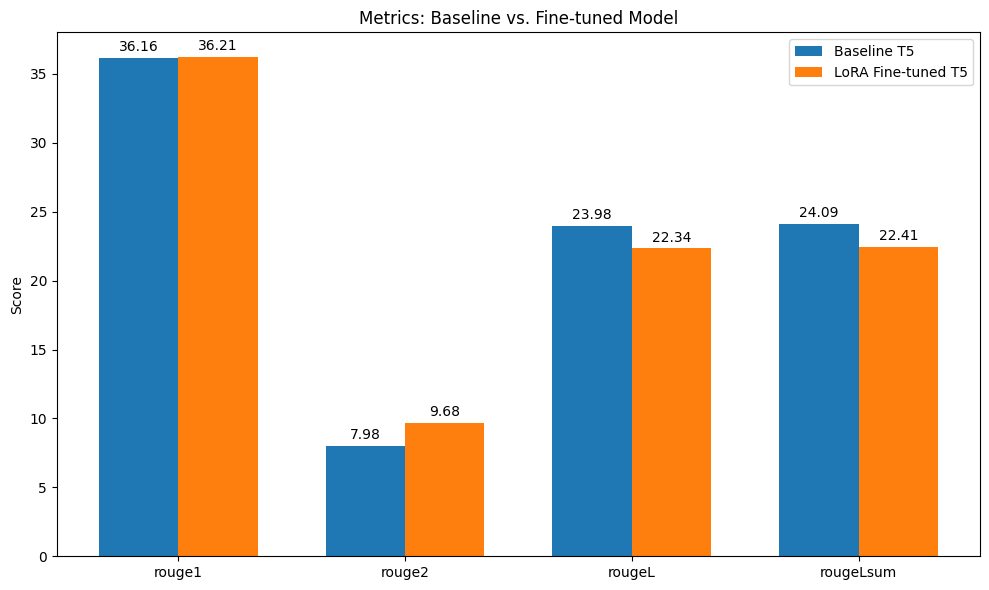

In [23]:
import matplotlib.pyplot as plt

def visualize_comparison(tuned_results, baseline_results):
    # Get common metrics
    metrics = [key for key in tuned_results.keys() if key in baseline_results]

    tuned_scores = [tuned_results[m] for m in metrics]
    baseline_scores = [baseline_results[m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    baseline_bars = ax.bar(x - width/2, baseline_scores, width, label='Baseline T5')
    tuned_bars = ax.bar(x + width/2, tuned_scores, width, label='LoRA Fine-tuned T5')

    ax.set_ylabel('Score')
    ax.set_title('Metrics: Baseline vs. Fine-tuned Model')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Add value labels on bars
    for i, v in enumerate(baseline_scores):
        ax.text(i - width/2, v + 0.5, f'{v:.2f}', ha='center')

    for i, v in enumerate(tuned_scores):
        ax.text(i + width/2, v + 0.5, f'{v:.2f}', ha='center')

    fig.tight_layout()
    plt.show()

# Visualize the results
visualize_comparison(tuned_results, baseline_results)

In [24]:
def generate_technical_report():
    # Model parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())

    # Training details
    training_details = {
        "base_model": "t5-small",
        "fine_tuning_method": "LoRA (Low-Rank Adaptation)",
        "training_examples": len(train_dataset),
        "validation_examples": len(val_dataset),
        "test_examples": len(test_dataset),
        "epochs": training_args.num_train_epochs,
        "learning_rate": training_args.learning_rate,
        "batch_size": training_args.per_device_train_batch_size,
        "total_parameters": total_params,
        "trainable_parameters": trainable_params,
        "trainable_percentage": trainable_params / total_params * 100,
        "lora_rank": 8,  # From your LoRA configuration
        "lora_alpha": 32,
        "lora_dropout": 0.1,
        "target_modules": ["q", "v"]
    }

    # Print report
    print("\nTechnical Parameters Report:")
    print("-" * 50)
    for key, value in training_details.items():
        print(f"{key}: {value}")
    print("-" * 50)

    return training_details

tech_report = generate_technical_report()


Technical Parameters Report:
--------------------------------------------------
base_model: t5-small
fine_tuning_method: LoRA (Low-Rank Adaptation)
training_examples: 15
validation_examples: 5
test_examples: 5
epochs: 3
learning_rate: 0.001
batch_size: 2
total_parameters: 60801536
trainable_parameters: 294912
trainable_percentage: 0.48504037792729443
lora_rank: 8
lora_alpha: 32
lora_dropout: 0.1
target_modules: ['q', 'v']
--------------------------------------------------
